<a href="https://colab.research.google.com/github/shreyah/SER/blob/main/Cremad_w2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
#@title Kaggle Credential

import json

username = "shreyahiyer" #@param {type: "string"}
api_key = "c0cc50ee341bb5faccbecdd9602ca537" #@param {type: "string"}


if username and api_key:
    token = {"username": username, "key": api_key}

    !mkdir ~/.kaggle
    !mkdir /content/.kaggle
    with open('/content/.kaggle/kaggle.json', 'w') as f:
        json.dump(token, f)

    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json

    print('Your are ready to use kaggle API!')


Your are ready to use kaggle API!


In [ ]:
!mkdir -p /content/data/cremad
!kaggle datasets download ejlok1/cremad


 99% 446M/451M [00:10<00:00, 44.1MB/s]
100% 451M/451M [00:10<00:00, 44.2MB/s]


In [ ]:
!unzip cremad.zip -d /content/data/cremad/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/cremad/AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: /content/data/cremad/AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: /content/data/cremad/AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: /content/data/cremad/AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: /content/data/cremad/AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: /content/data/cremad/AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: /content/data/cremad/Audio

In [ ]:
Crema = "/content/data/cremad/AudioWAV/"

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,neutral,/content/data/cremad/AudioWAV/1053_WSI_NEU_XX.wav
1,disgust,/content/data/cremad/AudioWAV/1064_IEO_DIS_MD.wav
2,disgust,/content/data/cremad/AudioWAV/1073_MTI_DIS_XX.wav
3,happy,/content/data/cremad/AudioWAV/1085_WSI_HAP_XX.wav
4,fear,/content/data/cremad/AudioWAV/1045_ITS_FEA_XX.wav


In [ ]:
i = 0
for dirpath, dirnames, filenames in os.walk(Crema):
    
    for filename in filenames:
        if i == 5:
            break
        print(filename.split('_'))
        i += 1

['1053', 'WSI', 'NEU', 'XX.wav']
['1064', 'IEO', 'DIS', 'MD.wav']
['1073', 'MTI', 'DIS', 'XX.wav']
['1085', 'WSI', 'HAP', 'XX.wav']
['1045', 'ITS', 'FEA', 'XX.wav']


In [ ]:
# mapping
crema_emotions_map = {
    'SAD': 'sad',
    'FEA': 'fear', 
    'HAP': 'happy', 
    'ANG': 'angry', 
    'DIS': 'disgust', 
    'NEU': 'neutral'
}
emotional_intensity_crema_map = {
    'HI': 'high', 
    'LO': 'low', 
    'MD': 'medium', 
    'XX': 'unknown'
}
sentence_map = {
    'DFA': "Don't forget a jacket", 
    'IEO': "It's eleven'o clock", 
    'IOM': 'I am on my way to the meeting', 
    'ITH': "I think i have a doctor's appointment", 
    'ITS': 'I think i have seen this before', 
    'IWL': 'I would like a new alarm clock', 
    'IWW': 'I wonder what this is about', 
    'MTI': 'Maybe tomorrow it will be cold', 
    'TAI': 'The airplane is almost full', 
    'TIE': 'That is exactly what happened', 
    'TSI': 'The surface is slick', 
    'WSI': 'Will stop in a couple of minutes'
}
male = set([1,5,11,14,15,16,17,19,22,23,26,27,31,32,33,34,35,36,38,39,40,41,42,44,45,48,50,51,57,59,62,64,65,66,67,68,69,70,71,77,80,81,83,85,86,87,88,90])
female = set(range(1,92)) - male

In [ ]:
crema_rows = list()
for dirpath, dirnames, filenames in os.walk(Crema):
    for filename in filenames:
        filename_breakdown = filename.split('_')
        crema_row = dict()
        crema_row['dataset_name'] = 'CREMA'
        crema_row['gender'] = 'male' if int(filename_breakdown[0][2:]) in male else 'female'
        crema_row['emotion'] = crema_emotions_map[filename_breakdown[2]] 
        #print(dirpath, dirnames, filenames)
        crema_row['path'] = Crema + filename
        #print(filename)
        #print(filename,emotional_intensity_crema_map[filename_breakdown[-1][:2]])
        #crema_row['emotional_intensity'] = emotional_intensity_crema_map[filename_breakdown[-1][:2]]
        crema_row['text'] = sentence_map[filename_breakdown[1]]
        crema_row['audio_file_name'] = filename
        crema_row['actor'] = int(filename_breakdown[0][2:])
        crema_rows.append(crema_row)

crema_df = pd.DataFrame(crema_rows)
crema_df.head()

,dataset_name,gender,emotion,path,text,audio_file_name,actor
0,CREMA,female,neutral,/content/data/cremad/AudioWAV/1053_WSI_NEU_XX.wav,Will stop in a couple of minutes,1053_WSI_NEU_XX.wav,53
1,CREMA,male,disgust,/content/data/cremad/AudioWAV/1064_IEO_DIS_MD.wav,It's eleven'o clock,1064_IEO_DIS_MD.wav,64
2,CREMA,female,disgust,/content/data/cremad/AudioWAV/1073_MTI_DIS_XX.wav,Maybe tomorrow it will be cold,1073_MTI_DIS_XX.wav,73
3,CREMA,male,happy,/content/data/cremad/AudioWAV/1085_WSI_HAP_XX.wav,Will stop in a couple of minutes,1085_WSI_HAP_XX.wav,85
4,CREMA,male,fear,/content/data/cremad/AudioWAV/1045_ITS_FEA_XX.wav,I think i have seen this before,1045_ITS_FEA_XX.wav,45


In [ ]:
df_train = crema_df[(crema_df.actor > 18) ]
df_val = crema_df[(crema_df.actor > 9) & (crema_df.actor <= 18) ]
df_test = crema_df[(crema_df.actor <= 9) ]

In [ ]:
df_train

,dataset_name,gender,emotion,path,text,audio_file_name,actor
0,CREMA,female,neutral,/content/data/cremad/AudioWAV/1053_WSI_NEU_XX.wav,Will stop in a couple of minutes,1053_WSI_NEU_XX.wav,53
1,CREMA,male,disgust,/content/data/cremad/AudioWAV/1064_IEO_DIS_MD.wav,It's eleven'o clock,1064_IEO_DIS_MD.wav,64
2,CREMA,female,disgust,/content/data/cremad/AudioWAV/1073_MTI_DIS_XX.wav,Maybe tomorrow it will be cold,1073_MTI_DIS_XX.wav,73
3,CREMA,male,happy,/content/data/cremad/AudioWAV/1085_WSI_HAP_XX.wav,Will stop in a couple of minutes,1085_WSI_HAP_XX.wav,85
4,CREMA,male,fear,/content/data/cremad/AudioWAV/1045_ITS_FEA_XX.wav,I think i have seen this before,1045_ITS_FEA_XX.wav,45
...,...,...,...,...,...,...,...
7436,CREMA,male,angry,/content/data/cremad/AudioWAV/1090_IWW_ANG_XX.wav,I wonder what this is about,1090_IWW_ANG_XX.wav,90
7438,CREMA,female,neutral,/content/data/cremad/AudioWAV/1075_DFA_NEU_XX.wav,Don't forget a jacket,1075_DFA_NEU_XX.wav,75
7439,CREMA,female,happy,/content/data/cremad/AudioWAV/1078_ITH_HAP_XX.wav,I think i have a doctor's appointment,1078_ITH_HAP_XX.wav,78
7440,CREMA,female,angry,/content/data/cremad/AudioWAV/1089_TAI_ANG_XX.wav,The airplane is almost full,1089_TAI_ANG_XX.wav,89


In [ ]:
df_val

,dataset_name,gender,emotion,path,text,audio_file_name,actor
11,CREMA,male,disgust,/content/data/cremad/AudioWAV/1011_TAI_DIS_XX.wav,The airplane is almost full,1011_TAI_DIS_XX.wav,11
22,CREMA,male,happy,/content/data/cremad/AudioWAV/1011_IWW_HAP_XX.wav,I wonder what this is about,1011_IWW_HAP_XX.wav,11
26,CREMA,female,fear,/content/data/cremad/AudioWAV/1010_IEO_FEA_MD.wav,It's eleven'o clock,1010_IEO_FEA_MD.wav,10
33,CREMA,female,disgust,/content/data/cremad/AudioWAV/1012_IEO_DIS_MD.wav,It's eleven'o clock,1012_IEO_DIS_MD.wav,12
36,CREMA,male,happy,/content/data/cremad/AudioWAV/1011_IOM_HAP_XX.wav,I am on my way to the meeting,1011_IOM_HAP_XX.wav,11
...,...,...,...,...,...,...,...
7389,CREMA,female,fear,/content/data/cremad/AudioWAV/1013_IWW_FEA_XX.wav,I wonder what this is about,1013_IWW_FEA_XX.wav,13
7398,CREMA,male,fear,/content/data/cremad/AudioWAV/1011_IWW_FEA_XX.wav,I wonder what this is about,1011_IWW_FEA_XX.wav,11
7425,CREMA,male,happy,/content/data/cremad/AudioWAV/1014_IEO_HAP_MD.wav,It's eleven'o clock,1014_IEO_HAP_MD.wav,14
7428,CREMA,female,fear,/content/data/cremad/AudioWAV/1013_TSI_FEA_XX.wav,The surface is slick,1013_TSI_FEA_XX.wav,13


In [ ]:
print(df_test.actor.value_counts())
print(df_val.actor.value_counts())
print(df_train.actor.value_counts())

7    82
6    82
5    82
4    82
3    82
1    82
2    81
9    76
8    76
Name: actor, dtype: int64
18    82
17    82
16    82
15    82
14    82
13    82
12    82
11    82
10    82
Name: actor, dtype: int64
91    82
87    82
29    82
33    82
37    82
      ..
78    82
82    82
86    82
76    81
19    76
Name: actor, Length: 73, dtype: int64


In [ ]:
print("Labels: ", df_train["emotion"].unique())
print()
df_train.groupby("emotion").count()[["path"]]

Labels:  ['neutral' 'disgust' 'happy' 'fear' 'angry' 'sad']



,path
emotion,
angry,1021
disgust,1021
fear,1021
happy,1021
neutral,874
sad,1021


Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa

# Monitor the training process
# !pip install wandb

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(df_train))
sample = df_train.iloc[idx]
path = sample["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 424
      Label: sad



For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [ ]:
save_path = "/content/data"


train_df = df_train.reset_index(drop=True)
test_df = df_test.reset_index(drop=True)
valid_df = df_val.reset_index(drop=True)
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
valid_df.to_csv(f"{save_path}/valid.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(5979, 7)
(725, 7)
(738, 7)


## Prepare Data for Training

In [ ]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/data/train.csv", 
    "validation": "/content/data/valid.csv",
    "test": "/content/data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]
print(train_dataset)
print(eval_dataset)

Using custom data configuration default-1641cbe29476389f


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-1641cbe29476389f/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['dataset_name', 'gender', 'emotion', 'path', 'text', 'audio_file_name', 'actor'],
    num_rows: 5979
})
Dataset({
    features: ['dataset_name', 'gender', 'emotion', 'path', 'text', 'audio_file_name', 'actor'],
    num_rows: 738
})


In [ ]:
# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

In [ ]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


In order to preprocess the audio into our classification model, we need to set up the relevant Wav2Vec2 assets regarding our language in this case `lighteternal/wav2vec2-large-xlsr-53-greek` fine-tuned by [Dimitris Papadopoulos](https://huggingface.co/lighteternal/wav2vec2-large-xlsr-53-greek). To handle the context representations in any audio length we use a merge strategy plan (pooling mode) to concatenate that 3D representations into 2D representations.

There are three merge strategies `mean`, `sum`, and `max`. In this example, we achieved better results on the mean approach. In the following, we need to initiate the config and the feature extractor from the Dimitris model.

In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor

In [49]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"

In [50]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

loading configuration file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/config.json from cache at /content/cache/d38103e58c39973cfd1e2ec80562af01ab4c06f185ec158a79b5fa19a4b63202.bab823bcb42c6a03806d450bd5c966d4586caa0d423bf9fa0d10206145b2ca75
/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Model config Wav2Vec2Config {
  "_name_or_path": "jonatasgrosman/wav2vec2-large-xlsr-53-english",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures"

In [51]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

loading feature extractor configuration file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/preprocessor_config.json from cache at /content/cache/fc6796f7821647c9688e7962f0ec34203c203d8bb6776a47ad1bcf0306eaa10c.bbc1eb890a39c82e710a893223b8452ac5b78e8b57083b2f893aa7dc59d4ed69
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

loading file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/vocab.json from cache at /content/cache/b34268eea9d69ccd2f8b4f2010bf9cab522e76694e411e632d73d859509777e2.9f37e4e9393449515984a1e0dc0de9182290d9a1f752a1515fb5c0e504811d52
loading file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingfa

The target sampling rate: 16000


# Preprocess Data

So far, we downloaded, loaded, and split the SER dataset into train and test sets. The instantiated our strategy configuration for using context representations in our classification problem SER. Now, we need to extract features from the audio path in context representation tensors and feed them into our classification model to determine the emotion in the speech.

Since the audio file is saved in the `.wav` format, it is easy to use **[Librosa](https://librosa.org/doc/latest/index.html)** or others, but we suppose that the format may be in the `.mp3` format in case of generality. We found that the **[Torchaudio](https://pytorch.org/audio/stable/index.html)** library works best for reading in `.mp3` data.

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a **map(...)** function accordingly. Also, we need to handle the string labels into integers for our specific classification task in this case, the **single-label classification** you may want to use for your **regression** or even **multi-label classification**.

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

In [ ]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.0025472729466855526, 0.00254727

Great, now we've successfully read all the audio files, resampled the audio files to 16kHz, and mapped each audio to the corresponding label.

## Model

Before diving into the training part, we need to build our classification model based on the merge strategy. 

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. There are many pre-defined metrics for classification/regression problems, but in this case, we would continue with just **Accuracy** for classification and **MSE** for regression. You can define other metrics on your own.

In [ ]:
is_regression = False

In [ ]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

Now, we can load the pretrained XLSR-Wav2Vec2 checkpoint into our classification model with a pooling strategy.

In [ ]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this mode

The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/wav2vec2-xlsr-cremaD-speech-emotion-recognition",
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.5,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1e-4,
    save_total_limit=2
)

For future use we can create our training script, we do it in a simple way. You can add more on you own.

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


### Training

Training will take between 10 and 60 minutes depending on the GPU allocated to this notebook. 

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: emotion, actor, text, dataset_name, path, audio_file_name, gender.
***** Running training *****
  Num examples = 5979
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 561
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


Step,Training Loss,Validation Loss,Accuracy
100,1.449000,1.096894,0.579946
200,1.047300,0.929992,0.634146
300,0.918000,0.783222,0.705962
400,0.836000,0.722711,0.754743
500,0.668300,0.690683,0.773713


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: emotion, actor, text, dataset_name, path, audio_file_name, gender.
***** Running Evaluation *****
  Num examples = 738
  Batch size = 16
Saving model checkpoint to /content/wav2vec2-xlsr-cremaD-speech-emotion-recognition/checkpoint-100
Configuration saved in /content/wav2vec2-xlsr-cremaD-speech-emotion-recognition/checkpoint-100/config.json
Model weights saved in /content/wav2vec2-xlsr-cremaD-speech-emotion-recognition/checkpoint-100/pytorch_model.bin
Configuration saved in /content/wav2vec2-xlsr-cremaD-speech-emotion-recognition/checkpoint-100/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This res

TrainOutput(global_step=561, training_loss=0.9477731633313837, metrics={'train_runtime': 6364.2988, 'train_samples_per_second': 1.409, 'train_steps_per_second': 0.088, 'total_flos': 8.811155760158606e+17, 'train_loss': 0.9477731633313837, 'epoch': 1.5})

The training loss goes down and we can see that the Acurracy on the test set also improves nicely. Because this notebook is just for demonstration purposes, we can stop here.

The resulting model of this notebook has been saved to [m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition](https://huggingface.co/m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition)

As a final check, let's load the model and verify that it indeed has learned to recognize the emotion in the speech.

Let's first load the pretrained checkpoint.

## Evaluation

In [84]:
import librosa
from sklearn.metrics import classification_report,confusion_matrix,f1_score

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#fn
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

In [43]:
test_dataset = load_dataset("csv", data_files={"test": "/content/data/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-b000c9c40055f084


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-b000c9c40055f084/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['dataset_name', 'gender', 'emotion', 'path', 'text', 'audio_file_name', 'actor'],
    num_rows: 725
})

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [53]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [54]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/725 [00:00<?, ?ex/s]

In [55]:
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/91 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [61]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

In [62]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[0, 2, 2, 0, 2]
[0, 2, 5, 0, 2]


In [92]:
print(classification_report(y_true, y_pred, target_names=label_names))
print('F1 score',round(f1_score(y_true, y_pred,average='weighted')*100,2))

              precision    recall  f1-score   support

       angry       0.75      0.83      0.79       124
     disgust       0.48      0.77      0.59       124
        fear       0.61      0.60      0.61       124
       happy       0.80      0.57      0.67       124
     neutral       0.93      0.67      0.78       105
         sad       0.62      0.52      0.56       124

    accuracy                           0.66       725
   macro avg       0.70      0.66      0.67       725
weighted avg       0.69      0.66      0.66       725

F1 score 66.28


TEST

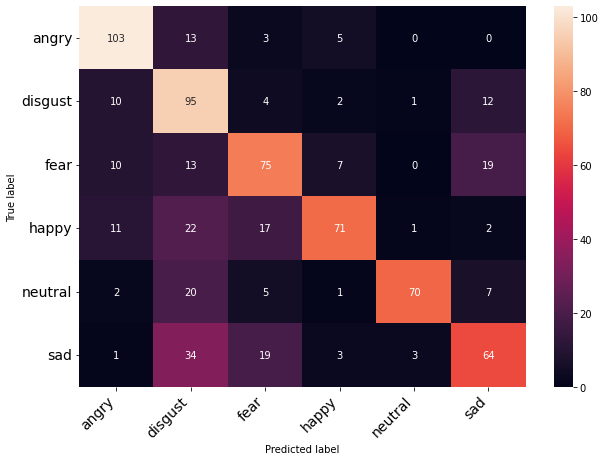

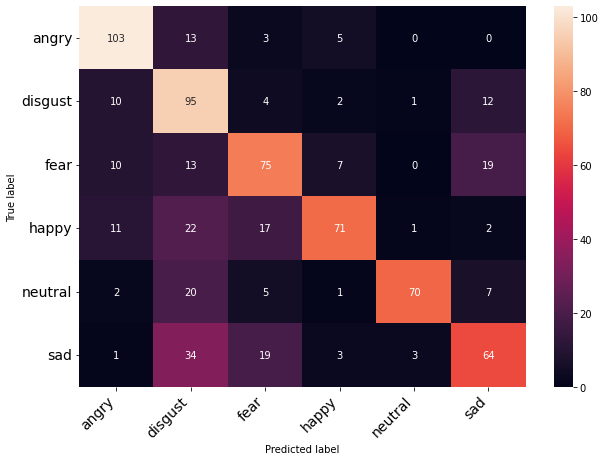

In [98]:
print_confusion_matrix((confusion_matrix(y_true, y_pred)),label_names)

# Prediction

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = "content/wav2vec2-xlsr-cremaD-speech-emotion-recognition/checkpoint-500"
model_name_or_path ='jonatasgrosman/wav2vec2-large-xlsr-53-english'
#config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
sampling_rate = processor.feature_extractor.sampling_rate
#model = Wav2Vec2ForSpeechClassification.from_pretrained(model_2).to(device)

loading feature extractor configuration file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/preprocessor_config.json from cache at /content/cache/fc6796f7821647c9688e7962f0ec34203c203d8bb6776a47ad1bcf0306eaa10c.bbc1eb890a39c82e710a893223b8452ac5b78e8b57083b2f893aa7dc59d4ed69
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

loading file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/vocab.json from cache at /content/cache/b34268eea9d69ccd2f8b4f2010bf9cab522e76694e411e632d73d859509777e2.9f37e4e9393449515984a1e0dc0de9182290d9a1f752a1515fb5c0e504811d52
loading file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingfa

In [75]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [76]:
test = pd.read_csv("/content/data/test.csv", sep="\t")
test.head()

,dataset_name,gender,emotion,path,text,audio_file_name,actor
0,CREMA,female,angry,/content/data/cremad/AudioWAV/1004_TIE_ANG_XX.wav,That is exactly what happened,1004_TIE_ANG_XX.wav,4
1,CREMA,female,fear,/content/data/cremad/AudioWAV/1002_IWL_FEA_XX.wav,I would like a new alarm clock,1002_IWL_FEA_XX.wav,2
2,CREMA,female,fear,/content/data/cremad/AudioWAV/1007_IWW_FEA_XX.wav,I wonder what this is about,1007_IWW_FEA_XX.wav,7
3,CREMA,female,angry,/content/data/cremad/AudioWAV/1008_IEO_ANG_MD.wav,It's eleven'o clock,1008_IEO_ANG_MD.wav,8
4,CREMA,female,fear,/content/data/cremad/AudioWAV/1002_IWW_FEA_XX.wav,I wonder what this is about,1002_IWW_FEA_XX.wav,2


In [77]:
prediction(test.iloc[0])

,Emotion,Sentence
0,angry,


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


,Emotion,Score
0,angry,98.6%
1,disgust,0.7%
2,fear,0.1%
3,happy,0.6%
4,neutral,0.0%
5,sad,0.0%


In [78]:
prediction(test.iloc[1])

,Emotion,Sentence
0,fear,


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


,Emotion,Score
0,angry,0.1%
1,disgust,3.2%
2,fear,71.8%
3,happy,0.7%
4,neutral,0.3%
5,sad,23.9%


In [79]:
prediction(test.iloc[2])

,Emotion,Sentence
0,fear,


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


,Emotion,Score
0,angry,0.0%
1,disgust,1.0%
2,fear,48.8%
3,happy,1.7%
4,neutral,2.3%
5,sad,46.1%


In [ ]:
print_confusion_matrix()